## Model Based Approach

In [304]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from surprise import evaluate, Reader, Dataset, SVD,SVDpp, NMF, GridSearch
from sklearn import preprocessing
import implicit
import scipy.sparse as sparse
import scipy
import matplotlib.pyplot as plt
plt.style.use('ggplot')

### Train and Test Data

Using our sampled data of popular songs and active users, we derived out training and test data set by holding out some of the listen count at random.  For example, one run we held out 20% of data for test and the remaining was used for training.  We could then use the train data to create the sparse matrix and have the test data to measure accuracy.

The training data has 88,359 triplets with 9,211 unique users and 100 unique songs.  The test data has 22,090 pairs with 7,002 unique users and 100 songs. 

In the test set, although there are ~7000 users there are only 997 users who listened to more than 5 songs. So we've employed an approach to run the tests on both test data sets to observe impact of latent factors on the Correct predictions and SSE. SSE in this case wasn't very helpful as the R[U][V] is more close to 1 with high certainity and not the actual numbr of listens. We see that the SSE value increases as the latent factors increase. And the best accuracy is around the latent factor 2.

In [271]:
def split_data_train_test_random(self, train_proportion, test_proportion, random_state=42):
    df_train, df_test = train_test_split(self, train_size=train_proportion, 
                                         test_size=test_proportion, random_state=42)
    return df_train, df_test

play = pd.read_csv('../DataSets/10kusers_100songs.csv', sep=',')
play.columns=['user','song','listen_count']

training_set,test_set = split_data_train_test_random(play,.8,.2)

In [272]:
training_set.shape

(88359, 3)

In [273]:
test_set.shape

(22090, 3)

In [274]:
train_users['user'] = pd.DataFrame(training_set['user'].unique())
train_songs['song'] = pd.DataFrame(training_set['song'].unique())

### The below methods compute the SSE and Coverage metrics

We noticed that the SSE is very huge in this dataset as predictions from implicit are in the range of 0-1 and are mainly intented for Top K predictions rather than the actual value.

The way we are calculating Coverage is to check for the presence of test data point in the Top K recommendations. We show further below that as the size of K in Top K predictions increase, we get a better hit.

In [301]:
grouped = test_set[['user','song','listen_count']].groupby('user')
test_grp = grouped.filter(lambda x: x['user'].count() > 5)
users = test_grp['user'].unique()
# print type(users)

def squaredError(users, songs, R, testRatings):
    error=0
    for i, j in testRatings.iterrows():
        try:
            pred = R[map(int, train_users.index[train_users['user'] ==j['user']])[0]][map(int, train_songs.index[train_songs['song'] ==j['song']])[0]]
        except: 
            continue               
        actual = j['listen_count']
        error+=(pred-actual)**2
    return error

def metricsRecommendations(users, model, matrix, testRatings, topK=10):
    recommended=0
    missed=0
    ctr = 0
    found=0
    no_training=0
    
    for i,j in testRatings.iterrows():        
        try:
            topRecommends = model.recommend(map(int, train_users.index[train_users['user'] ==j['user']])[0],
                                               matrix, topK)
        except: 
            no_training+=1
            continue
            
        for k in range(len(topRecommends)):
            if topRecommends[k][0] == map(int, train_songs.index[train_songs['song'] ==j['song']])[0] :
                recommended+=1
                found=1
        if found==1 :
            found=0
        else :
            missed+=1
            
    return recommended, missed, no_training

print metricsRecommendations(users, model, sparse_user_item, test_set, 5)
print squaredError(train_users, train_songs, R, test_set)

(1104, 20735, 251)
1878213.6296167234


#### In the plot below, we show that as the number of Latent factors increase, SSE is increasing as well.

In [317]:
#change in factors vs squared error and correct recommendations
factors_t=[3,6,9,12,15,18,21]
sqErr_t=[]
corrRecom_t=[]
for f in factors_t:
    model = implicit.als.AlternatingLeastSquares(factors=f, regularization=0.01, iterations=500)
    model.fit(sparse_item_user)
    U = model.user_factors
    V = model.item_factors
    sparse_user_item = sparse_item_user.T.tocsr()
    R = np.matmul(U,np.transpose(V))
    
    corrRecom_t.append(metricsRecommendations(users, model, sparse_user_item, test_set, 10)[0])
    sqErr_t.append(squaredError(train_users, train_songs, R, test_set))
        
print 'done'

100%|██████████| 500.0/500 [00:08<00:00, 60.12it/s]
100%|██████████| 500.0/500 [00:09<00:00, 55.00it/s]
100%|██████████| 500.0/500 [00:08<00:00, 56.34it/s]
100%|██████████| 500.0/500 [00:08<00:00, 56.43it/s]
100%|██████████| 500.0/500 [00:09<00:00, 54.18it/s]
100%|██████████| 500.0/500 [00:09<00:00, 54.34it/s]
100%|██████████| 500.0/500 [00:09<00:00, 52.31it/s]


done


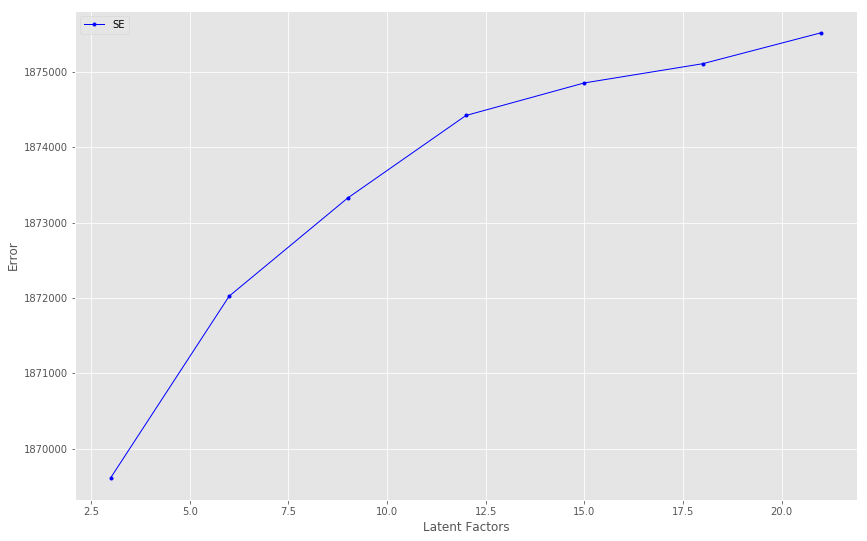

In [326]:
#plot factors vs error
    
plot1=pd.DataFrame({'factors_t':factors_t,'sqErr_t':sqErr_t, 'corrRecom_t':corrRecom_t})
plt.plot('factors_t', 'sqErr_t', data=plot1, label='SE', 
         marker='o', markerfacecolor='blue', markersize=3, color='blue', linewidth=1)
plt.xlabel('Latent Factors')
plt.ylabel('Error')
plt.legend()
plt.rcParams["figure.figsize"] = [20,16]
plt.show()

#### We noticed better hit on Coverage at Latent factors 3. 

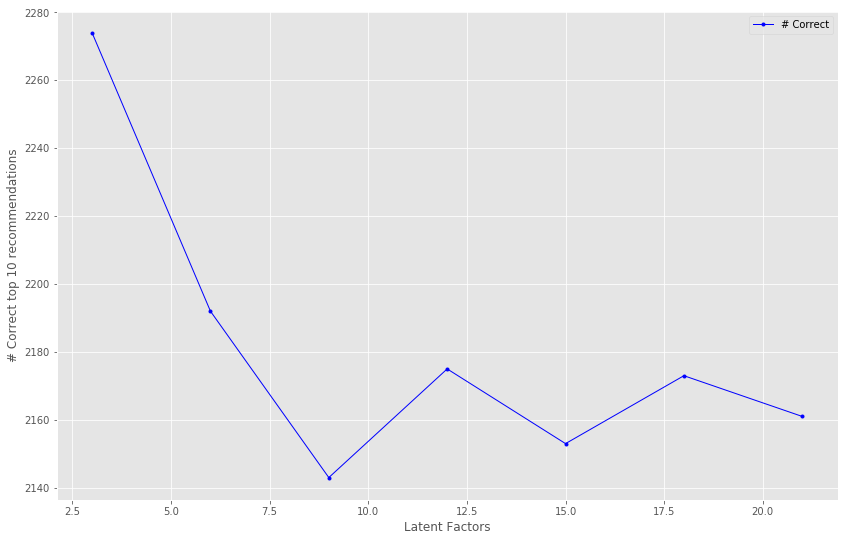

In [328]:
#plot factors vs percent recommendation correctness
plt.plot('factors_t', 'corrRecom_t', data=plot1, label='# Correct', 
         marker='o', markerfacecolor='blue', markersize=3, color='blue', linewidth=1)
plt.xlabel('Latent Factors')
plt.ylabel('# Correct top 10 recommendations')
plt.legend()
plt.rcParams["figure.figsize"] = [14,9]
plt.show()

#### The below test is based on a subset of Test Dataset which contains only the users who listened  to more than 5 songs. The results are similar to the bigger data set.

In [302]:
#change in factors vs squared error and correct recommendations
factors=[3,6,9,12,15,18,21]
sqErr=[]
corrRecom=[]
for f in factors:
    model = implicit.als.AlternatingLeastSquares(factors=f, regularization=0.01, iterations=500)
    model.fit(sparse_item_user)
    U = model.user_factors
    V = model.item_factors
    sparse_user_item = sparse_item_user.T.tocsr()
    R = np.matmul(U,np.transpose(V))
    
    corrRecom.append(metricsRecommendations(users, model, sparse_user_item, test_grp, 10)[0])
    sqErr.append(squaredError(train_users, train_songs, R, test_grp))
        
print 'done'

100%|██████████| 500.0/500 [00:08<00:00, 59.72it/s]
100%|██████████| 500.0/500 [00:10<00:00, 46.07it/s]
100%|██████████| 500.0/500 [00:09<00:00, 54.90it/s]
100%|██████████| 500.0/500 [00:08<00:00, 55.95it/s]
100%|██████████| 500.0/500 [00:09<00:00, 52.83it/s]
100%|██████████| 500.0/500 [00:09<00:00, 52.28it/s]
100%|██████████| 500.0/500 [00:09<00:00, 50.89it/s]


done


### For the graphs below, correctness is defined as the number of top K recommendations that have been actually listened to by the user based on the test set

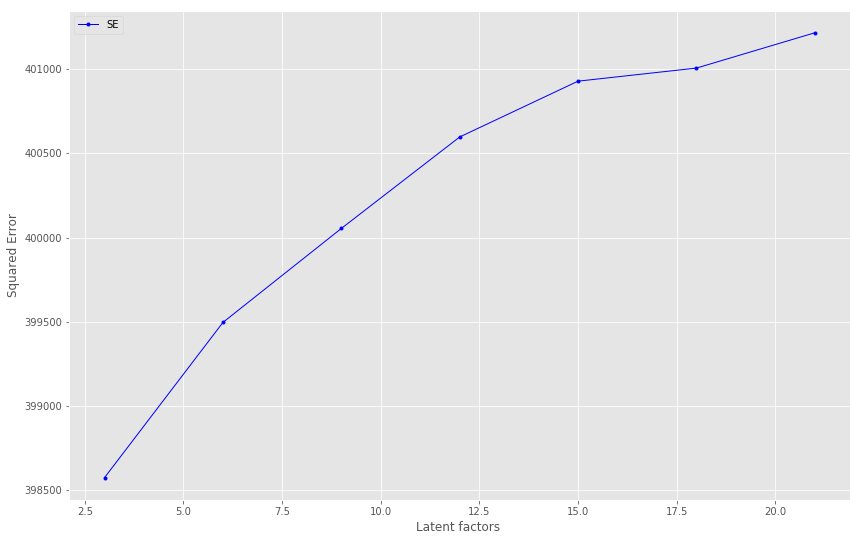

In [329]:
#plot factors vs error
    
plot1=pd.DataFrame({'factors':factors,'sqErr':sqErr, 'corrRecom':corrRecom})
plt.plot('factors', 'sqErr', data=plot1, label='SE', 
         marker='o', markerfacecolor='blue', markersize=3, color='blue', linewidth=1)
plt.xlabel('Latent factors ')
plt.ylabel('Squared Error')
plt.legend()
plt.rcParams["figure.figsize"] = [20,12]
plt.show()

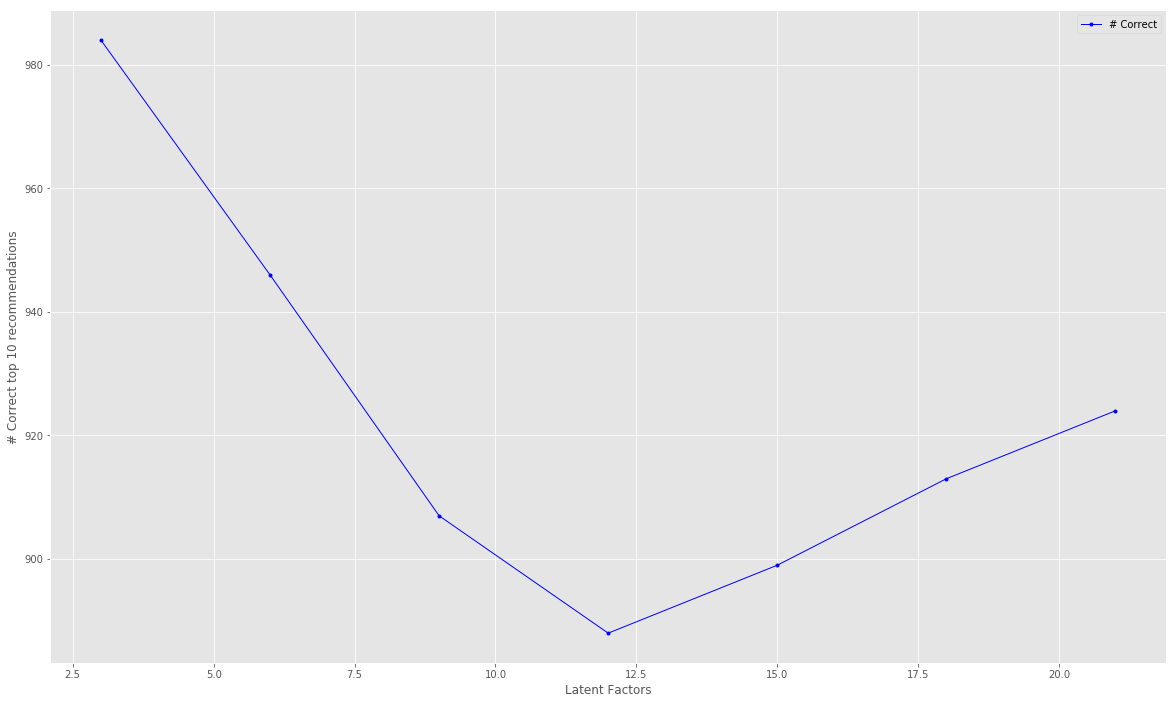

In [330]:
#plot factors vs percent recommendation correctness
plt.plot('factors', 'corrRecom', data=plot1, label='# Correct', 
         marker='o', markerfacecolor='blue', markersize=3, color='blue', linewidth=1)
plt.xlabel('Latent Factors')
plt.ylabel('# Correct top 10 recommendations')
plt.legend()
plt.rcParams["figure.figsize"] = [14,9]
plt.show()

### Correct top recommendations where k = 5,10,15,20,25

The number of correct Top K predictions are increasing as N is increasing.

In [335]:
#change in factors vs squared error and correct recommendations
k=[5,10,15,20,25]
corrRecom_k=[]

model = implicit.als.AlternatingLeastSquares(factors=3, regularization=0.01, iterations=500)
model.fit(sparse_item_user)
U = model.user_factors
V = model.item_factors
sparse_user_item = sparse_item_user.T.tocsr()
R = np.matmul(U,np.transpose(V))
    
for f in range(len(k)):    
    corrRecom_k.append(metricsRecommendations(users, model, sparse_user_item, test_set, k[f])[0])
        
print 'done'

100%|██████████| 500.0/500 [00:09<00:00, 55.36it/s]


done


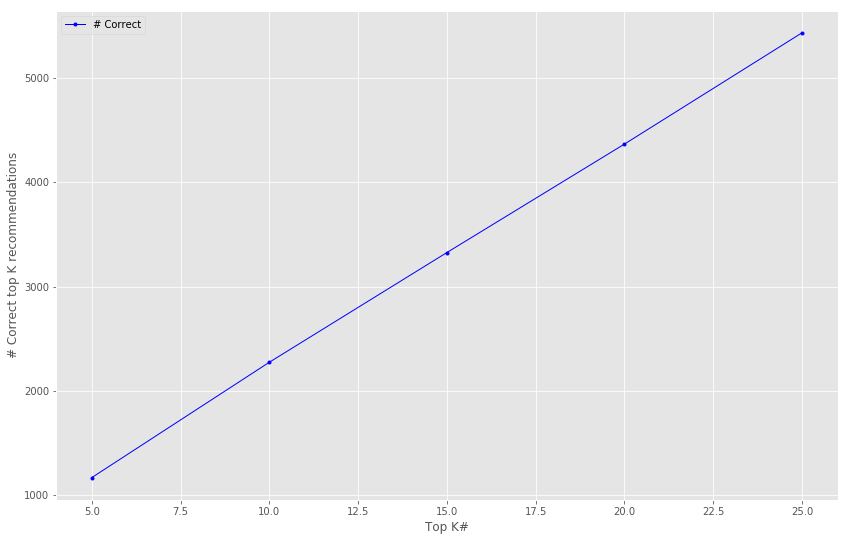

In [336]:
plot1=pd.DataFrame({'k':k,'corrRecom_k':corrRecom_k})
plt.plot('k', 'corrRecom_k', data=plot1, label='# Correct', 
         marker='o', markerfacecolor='blue', markersize=3, color='blue', linewidth=1)
plt.xlabel('Top K#')
plt.ylabel('# Correct top K recommendations')
plt.legend()
plt.rcParams["figure.figsize"] = [14,9]
plt.show()